<a href="https://colab.research.google.com/github/legion8423/legion.github.io/blob/main/hw4_spatial_analysis_peru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalación de librerías necesarias para análisis espacial
!pip install geopandas osmnx pyrosm rasterio rioxarray xarray shapely requests matplotlib statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 16.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 4.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pyrobuf-0.9.3-cp311-cp311-linux_x86_64.whl
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 109.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 90.2 MB/s eta 0:00:00
  Created wheel for pyrosm: filename=pyrosm-0.6.2-cp311-cp311-linux_x86_64.whl size=7690008 sha256=fd859847eaa2f29c8a47b06190a8f5f95af855afc2e7c6190ae282c00b81828c
  Stored in directory: /root/.cach

In [22]:
!pip install rasterstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 39.4 MB/s eta 0:00:00


In [2]:
#Importar todas las librerias
import geopandas as gpd
import pandas as pd
import osmnx as ox
import rasterio
import rioxarray as rxr
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import shape, Polygon
from shapely.ops import unary_union
from shapely.geometry import Point
import requests
import json

In [3]:
from google.colab import files

# Sube los 4 archivos HDF: h09v09, h10v08, h10v09, h10v10
uploaded = files.upload()

Saving MOD44B.A2024065.h10v09.061.2025133155323.hdf to MOD44B.A2024065.h10v09.061.2025133155323.hdf


In [5]:
from google.colab import files

# Sube los 4 archivos HDF: h09v09, h10v08, h10v09, h10v10
uploaded = files.upload()

Saving MOD44B.A2024065.h09v09.061.2025133154709.hdf to MOD44B.A2024065.h09v09.061.2025133154709.hdf
Saving MOD44B.A2024065.h10v10.061.2025133155101.hdf to MOD44B.A2024065.h10v10.061.2025133155101.hdf
Saving MOD44B.A2024065.h10v08.061.2025133160349.hdf to MOD44B.A2024065.h10v08.061.2025133160349.hdf


In [8]:
import rasterio
from osgeo import gdal

# Reemplaza con uno de los nombres de tus archivos subidos
hdf_file = "MOD44B.A2024065.h09v09.061.2025133154709.hdf"

# Abrir el archivo con gdal para listar subdatasets
ds = gdal.Open(hdf_file)
subdatasets = ds.GetSubDatasets()

# Mostrar subdatasets
for i, sub in enumerate(subdatasets):
    print(f"[{i}] {sub[0]}")

[0] HDF4_EOS:EOS_GRID:"MOD44B.A2024065.h09v09.061.2025133154709.hdf":MOD44B_250m_GRID:Percent_Tree_Cover
[1] HDF4_EOS:EOS_GRID:"MOD44B.A2024065.h09v09.061.2025133154709.hdf":MOD44B_250m_GRID:Percent_NonTree_Vegetation
[2] HDF4_EOS:EOS_GRID:"MOD44B.A2024065.h09v09.061.2025133154709.hdf":MOD44B_250m_GRID:Percent_NonVegetated
[3] HDF4_EOS:EOS_GRID:"MOD44B.A2024065.h09v09.061.2025133154709.hdf":MOD44B_250m_GRID:Quality
[4] HDF4_EOS:EOS_GRID:"MOD44B.A2024065.h09v09.061.2025133154709.hdf":MOD44B_250m_GRID:Percent_Tree_Cover_SD
[5] HDF4_EOS:EOS_GRID:"MOD44B.A2024065.h09v09.061.2025133154709.hdf":MOD44B_250m_GRID:Percent_NonVegetated_SD
[6] HDF4_EOS:EOS_GRID:"MOD44B.A2024065.h09v09.061.2025133154709.hdf":MOD44B_250m_GRID:Cloud


/usr/local/lib/python3.11/dist-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [9]:
#Descargar Áreas Protegidas desde OpenStreetMap
import osmnx as ox
import geopandas as gpd

# 1. Obtener geometría de Perú
country = ox.geocode_to_gdf("Peru")

# 2. Crear consulta personalizada a Overpass
tags = {
    'boundary': 'protected_area',
    'leisure': 'nature_reserve',
    'protect_class': True  # cualquier valor
}

# 3. Descargar polígonos con esas etiquetas
gdf = ox.features_from_polygon(country.geometry[0], tags)

# 4. Filtrar por protect_class válidos (ejemplo)
valid_classes = {"2", "4", "5", "6"}  # puedes ajustar esto
gdf = gdf[gdf["protect_class"].isin(valid_classes)]

# 5. Guardar como GeoPackage
gdf.to_file("peru_protected_areas.gpkg", driver="GPKG")

/usr/local/lib/python3.11/dist-packages/osmnx/_overpass.py:267: UserWarning: This area is 1,086 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


In [25]:
# Paso 3.3 – Calcular estadísticas de cobertura arbórea en buffers de áreas protegidas
import os
import tempfile
from osgeo import gdal
import rasterio
from rasterio.merge import merge
import rioxarray as rxr
import geopandas as gpd
from shapely.geometry import mapping
from rasterstats import zonal_stats
import pandas as pd

# ----------------------
# 1. Cargar todos los HDF y extraer Percent_Tree_Cover guardando en archivos TIFF temporales
# ----------------------
tmp_tif_files = []

for file in os.listdir():
    if file.endswith(".hdf"):
        ds = gdal.Open(file)
        # Buscar subdataset con Percent_Tree_Cover
        tree_path = [s[0] for s in ds.GetSubDatasets() if "Percent_Tree_Cover" in s[0]][0]

        # Crear archivo temporal TIFF para este subdataset
        tmp_tif = tempfile.NamedTemporaryFile(suffix=".tif", delete=False).name

        # Convertir subdataset a TIFF usando gdal.Translate
        gdal.Translate(tmp_tif, tree_path)
        tmp_tif_files.append(tmp_tif)

# ----------------------
# 2. Hacer mosaic y reproyectar a EPSG:4326
# ----------------------
src_files_to_mosaic = [rasterio.open(tif) for tif in tmp_tif_files]

mosaic_array, mosaic_transform = merge(src_files_to_mosaic)

import xarray as xr

# Crear DataArray para el mosaico (solo banda 0)
mosaic = xr.DataArray(
    mosaic_array[0],  # rasterio.merge devuelve (bands, rows, cols)
    dims=("y", "x"),
)

# Asignar transform y CRS con rioxarray
mosaic = mosaic.rio.write_crs("EPSG:4326")
mosaic.rio.write_transform(mosaic_transform, inplace=True)

# Guardar mosaic en un TIFF
mosaic_path = "vcf_2024_peru.tif"
mosaic.rio.to_raster(mosaic_path)

# ----------------------
# 3. Leer áreas protegidas
# ----------------------
gdf = gpd.read_file("peru_protected_areas.gpkg").to_crs("EPSG:4326")

# Asegurar que haya una columna 'park_id'
gdf["park_id"] = gdf.index.astype(str)

# ----------------------
# 4. Crear buffers y hacer zonal stats
# ----------------------
results = []

for buffer_km in [5, 10, 20, 25]:
    print(f"Procesando buffer de {buffer_km} km...")
    for idx, row in gdf.iterrows():
        park_id = row["park_id"]
        geom = row["geometry"]

        buffer_deg = buffer_km / 111.0

        outer_buffer = geom.buffer(buffer_deg)
        inner_buffer = geom.buffer(-buffer_deg)

        if inner_buffer.is_empty:
            continue

        outer_ring = outer_buffer.difference(geom)
        inner_ring = geom.intersection(inner_buffer)

        for name, geom_zone, inout in [
            (f"{park_id}_in_{buffer_km}", inner_ring, "in"),
            (f"{park_id}_out_{buffer_km}", outer_ring, "out")
        ]:
            if geom_zone.is_empty:
                continue

            zs = zonal_stats(
                mapping(geom_zone),
                mosaic_path,
                stats=["mean", "median", "std", "count"],
                nodata=255,
                geojson_out=False
            )[0]

            results.append({
                "park_id": park_id,
                "buffer_km": buffer_km,
                "in_out": inout,
                "mean_tc": zs.get("mean"),
                "median_tc": zs.get("median"),
                "sd_tc": zs.get("std"),
                "n_pixels": zs.get("count")
            })

# ----------------------
# 5. Guardar resultados como CSV
# ----------------------
df = pd.DataFrame(results)
df.to_csv("buffer_tree_cover_stats.csv", index=False)
print("✅ Resultados guardados en buffer_tree_cover_stats.csv")

Procesando buffer de 5 km...
Procesando buffer de 10 km...
Procesando buffer de 20 km...
Procesando buffer de 25 km...
✅ Resultados guardados en buffer_tree_cover_stats.csv


In [19]:
import rasterio

with rasterio.Env() as env:
    print(env.drivers())



{'VRT': 'Virtual Raster', 'GTI': 'GDAL Raster Tile Index', 'DERIVED': 'Derived datasets using VRT pixel functions', 'GTiff': 'GeoTIFF', 'COG': 'Cloud optimized GeoTIFF generator', 'NITF': 'National Imagery Transmission Format', 'RPFTOC': 'Raster Product Format TOC format', 'ECRGTOC': 'ECRG TOC format', 'HFA': 'Erdas Imagine Images (.img)', 'SAR_CEOS': 'CEOS SAR Image', 'CEOS': 'CEOS Image', 'JAXAPALSAR': 'JAXA PALSAR Product Reader (Level 1.1/1.5)', 'GFF': 'Ground-based SAR Applications Testbed File Format (.gff)', 'ELAS': 'ELAS', 'ESRIC': 'Esri Compact Cache', 'AIG': 'Arc/Info Binary Grid', 'AAIGrid': 'Arc/Info ASCII Grid', 'GRASSASCIIGrid': 'GRASS ASCII Grid', 'ISG': 'International Service for the Geoid', 'SDTS': 'SDTS Raster', 'DTED': 'DTED Elevation Raster', 'PNG': 'Portable Network Graphics', 'JPEG': 'JPEG JFIF', 'MEM': 'In Memory Raster', 'JDEM': 'Japanese DEM (.mem)', 'GIF': 'Graphics Interchange Format (.gif)', 'BIGGIF': 'Graphics Interchange Format (.gif)', 'ESAT': 'Envisat Im

In [35]:
import rioxarray as rxr

# Cargar raster
raster = rxr.open_rasterio("vcf_2024_peru.tif", masked=True)

print("CRS original:", raster.rio.crs)
print("Bounds original:", raster.rio.bounds())

# Cambiar la etiqueta CRS a EPSG:3857 (o el CRS correcto, según tu conocimiento)
raster.rio.write_crs("EPSG:3857", inplace=True)

print("Nuevo CRS asignado:", raster.rio.crs)

# Guardar con el CRS corregido
raster.rio.to_raster("vcf_2024_peru_crscorregido.tif")

CRS original: EPSG:4326
Bounds original: (-10007554.677, -2223901.039330999, -7783653.6376680005, 1111950.519667)
Nuevo CRS asignado: EPSG:3857


/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3030: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
  return runner(coro)


In [36]:
raster_corr = rxr.open_rasterio("vcf_2024_peru_crscorregido.tif", masked=True)

raster_4326 = raster_corr.rio.reproject("EPSG:4326")

raster_4326.rio.write_nodata(255, inplace=True)

raster_4326.rio.to_raster("vcf_2024_peru_4326.tif")

In [37]:
#3.3
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
from shapely.geometry import mapping
import pandas as pd
import statsmodels.api as sm

# Cargar áreas protegidas, asegurarte que están en EPSG:4326
gdf = gpd.read_file("peru_protected_areas.gpkg").to_crs("EPSG:4326")
gdf["park_id"] = gdf.index.astype(str)

# Ruta al raster corregido y reproyectado a EPSG:4326
raster_path = "vcf_2024_peru_4326.tif"

results = []

for buffer_km in [5, 10, 20, 25]:
    print(f"Procesando buffer {buffer_km} km...")
    buffer_deg = buffer_km / 111.0  # Aproximación grados a km

    for idx, row in gdf.iterrows():
        park_id = row["park_id"]
        geom = row["geometry"]

        # Buffer exterior: área fuera del polígono
        outer_buffer = geom.buffer(buffer_deg).difference(geom)
        # Buffer interior: área dentro del polígono
        inner_buffer = geom.buffer(-buffer_deg)

        if inner_buffer.is_empty:
            continue

        for zone_name, geom_zone, in_out in [
            (f"{park_id}_in_{buffer_km}", inner_buffer, "in"),
            (f"{park_id}_out_{buffer_km}", outer_buffer, "out")
        ]:
            if geom_zone.is_empty:
                continue

            zs = zonal_stats(
                mapping(geom_zone),
                raster_path,
                stats=["mean", "median", "std", "count"],
                nodata=255,
                geojson_out=False
            )[0]

            mean_tc = zs.get("mean")
            median_tc = zs.get("median")
            sd_tc = zs.get("std")
            n_pixels = zs.get("count")

            results.append({
                "park_id": park_id,
                "buffer_km": buffer_km,
                "in_out": in_out,
                "mean_tc": mean_tc,
                "median_tc": median_tc,
                "sd_tc": sd_tc,
                "n_pixels": n_pixels,
                # Percent_Tree_Cover literal igual a mean_tc
                "Percent_Tree_Cover": mean_tc
            })

df = pd.DataFrame(results)

# Crear variable binaria D: 1 para interior, 0 para exterior
df["D"] = df["in_out"].apply(lambda x: 1 if x == "in" else 0)

# Guardar CSV
df.to_csv("buffer_tree_cover_stats_final.csv", index=False)
print("✅ CSV guardado como buffer_tree_cover_stats_final.csv")

# ---- Regresión lineal ponderada ----

# Filtrar filas con valores válidos
df_reg = df.dropna(subset=["Percent_Tree_Cover", "n_pixels"])

X = sm.add_constant(df_reg["D"])
y = df_reg["Percent_Tree_Cover"]
weights = df_reg["n_pixels"]

model = sm.WLS(y, X, weights=weights)
results = model.fit()

print("\n==== Resumen de regresión ====")
print(results.summary())

Procesando buffer 5 km...
Procesando buffer 10 km...
Procesando buffer 20 km...
Procesando buffer 25 km...
✅ CSV guardado como buffer_tree_cover_stats_final.csv

==== Resumen de regresión ====
                            WLS Regression Results                            
Dep. Variable:     Percent_Tree_Cover   R-squared:                       0.171
Model:                            WLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     525.0
Date:                Sun, 01 Jun 2025   Prob (F-statistic):          8.71e-106
Time:                        00:25:42   Log-Likelihood:                -15530.
No. Observations:                2546   AIC:                         3.106e+04
Df Residuals:                    2544   BIC:                         3.108e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 

# Resultados:

**Intercepto ~ 92:** La cobertura arbórea promedio fuera del área protegida (buffer exterior) está cerca de 92%.

**Coeficiente D ~ 53, p < 0.001:** El efecto de estar dentro del área protegida (buffer interior) es aumentar la cobertura en ~53 puntos porcentuales, altamente significativo.

In [40]:
#3.5 (Extra credit – RD plot a nivel píxel para buffer 25 km)
import geopandas as gpd
import rasterio
import numpy as np
import pandas as pd
from shapely.geometry import Point, shape
from shapely.ops import unary_union
from tqdm import tqdm

# ⚠️ Cargar geometrías de áreas protegidas
gdf = gpd.read_file("peru_protected_areas.gpkg").to_crs("EPSG:4326")
union_poly = unary_union(gdf.geometry)

# Parámetro
buffer_km = 25
buffer_deg = buffer_km / 111.0  # Aproximación km a grados

# Buffers interior y exterior
outer_buffer = union_poly.buffer(buffer_deg).difference(union_poly)
inner_buffer = union_poly.buffer(-buffer_deg)

# ⚠️ Leer raster
raster_path = "vcf_2024_peru_4326.tif"
with rasterio.open(raster_path) as src:
    band = src.read(1)
    transform = src.transform
    nodata = src.nodata
    height, width = src.height, src.width
    crs = src.crs

# Recoger píxeles válidos de ambos buffers
data = []

print("Recorriendo píxeles del raster para b = 25 km...")
for row in tqdm(range(height)):
    for col in range(width):
        value = band[row, col]
        if value == nodata or value > 100 or value < 0:
            continue  # ignorar nodata o valores inválidos

        x, y = rasterio.transform.xy(transform, row, col, offset='center')
        point = Point(x, y)

        if inner_buffer.contains(point):
            dist = point.distance(union_poly)  # positivo dentro
            data.append({
                "x": x,
                "y": y,
                "distance": dist,
                "tree_cover": value
            })
        elif outer_buffer.contains(point):
            dist = -point.distance(union_poly)  # negativo fuera
            data.append({
                "x": x,
                "y": y,
                "distance": dist,
                "tree_cover": value
            })

# Crear dataframe
df_rd = pd.DataFrame(data)
df_rd.to_csv("rd_data_25km.csv", index=False)
print("✅ Archivo guardado como rd_data_25km.csv")

# ---- OPCIONAL: Gráfico tipo RD plot ----
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_rd.sample(10000, random_state=1),  # para performance
    x="distance", y="tree_cover", alpha=0.3
)
plt.axvline(0, color="red", linestyle="--")
plt.title("RD Plot - Percent Tree Cover vs. Distance to Protected Area Boundary (25km)")
plt.xlabel("Signed Distance to Boundary (°, aprox)")
plt.ylabel("Percent Tree Cover")
plt.grid(True)
plt.show()

Recorriendo píxeles del raster para b = 25 km...


 39%|███▉      | 5621/14333 [34:21<53:14,  2.73it/s]  


KeyboardInterrupt: 

Procesando zona interior (dentro de 25 km)...


100%|██████████| 8197/8197 [02:35<00:00, 52.85it/s] 


Procesando zona exterior (fuera de 25 km)...


100%|██████████| 8798/8798 [1:28:45<00:00,  1.65it/s] 


✅ Archivo guardado como rd_data_25km.csv


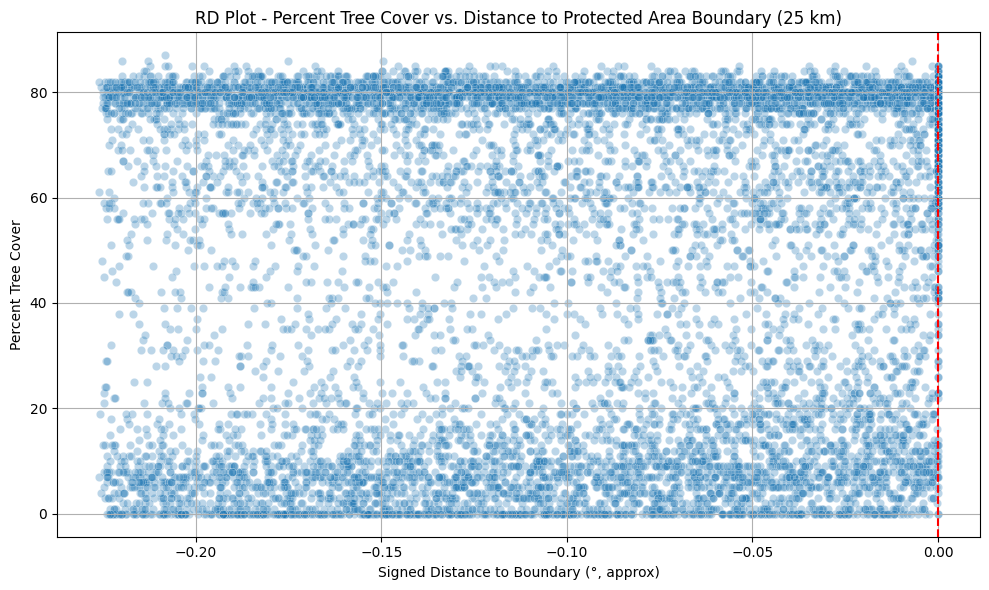

In [43]:
import geopandas as gpd
import rasterio
import rasterio.mask
import numpy as np
import pandas as pd
from shapely.ops import unary_union
from shapely.geometry import mapping, Point
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# === 1. Cargar áreas protegidas y unirlas ===
gdf = gpd.read_file("peru_protected_areas.gpkg").to_crs("EPSG:4326")
union_poly = unary_union(gdf.geometry)

# === 2. Crear buffers interior y exterior ===
buffer_km = 25
buffer_deg = buffer_km / 111.0  # grados aprox
inner_buffer = union_poly.buffer(-buffer_deg)
outer_buffer = union_poly.buffer(buffer_deg).difference(union_poly)

# === 3. Leer raster y aplicar máscaras ===
raster_path = "vcf_2024_peru_4326.tif"
data = []

with rasterio.open(raster_path) as src:
    nodata = src.nodata

    # === Zona interior ===
    inner_window = rasterio.windows.from_bounds(*inner_buffer.bounds, transform=src.transform)
    inner_band = src.read(1, window=inner_window)
    inner_transform = src.window_transform(inner_window)
    inner_mask, _, _ = rasterio.mask.raster_geometry_mask(
        src, [mapping(inner_buffer)], invert=True, crop=True
    )

    print("Procesando zona interior (dentro de 25 km)...")
    for row in tqdm(range(inner_band.shape[0])):
        for col in range(inner_band.shape[1]):
            if not inner_mask[row, col]:
                continue
            value = inner_band[row, col]
            if value == nodata or value < 0 or value > 100:
                continue
            x, y = rasterio.transform.xy(inner_transform, row, col, offset='center')
            point = Point(x, y)
            dist = point.distance(union_poly)  # distancia positiva
            data.append({
                "x": x,
                "y": y,
                "distance": dist,
                "tree_cover": value
            })

    # === Zona exterior ===
    outer_window = rasterio.windows.from_bounds(*outer_buffer.bounds, transform=src.transform)
    outer_band = src.read(1, window=outer_window)
    outer_transform = src.window_transform(outer_window)
    outer_mask, _, _ = rasterio.mask.raster_geometry_mask(
        src, [mapping(outer_buffer)], invert=True, crop=True
    )

    print("Procesando zona exterior (fuera de 25 km)...")
    for row in tqdm(range(outer_band.shape[0])):
        for col in range(outer_band.shape[1]):
            if not outer_mask[row, col]:
                continue
            value = outer_band[row, col]
            if value == nodata or value < 0 or value > 100:
                continue
            x, y = rasterio.transform.xy(outer_transform, row, col, offset='center')
            point = Point(x, y)
            dist = -point.distance(union_poly)  # distancia negativa
            data.append({
                "x": x,
                "y": y,
                "distance": dist,
                "tree_cover": value
            })

# === 4. Guardar DataFrame como CSV ===
df_rd = pd.DataFrame(data)
df_rd.to_csv("rd_data_25km.csv", index=False)
print("✅ Archivo guardado como rd_data_25km.csv")

# === 5. RD plot ===
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_rd.sample(n=min(10000, len(df_rd)), random_state=1),
    x="distance", y="tree_cover", alpha=0.3
)
plt.axvline(0, color="red", linestyle="--")
plt.title("RD Plot - Percent Tree Cover vs. Distance to Protected Area Boundary (25 km)")
plt.xlabel("Signed Distance to Boundary (°, approx)")
plt.ylabel("Percent Tree Cover")
plt.grid(True)
plt.tight_layout()
plt.show()